In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import psth 

/Users/pavanramkumar/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Load data

In [2]:
import scipy.io
#path_to_data = '/Volumes/JUICE/lab projects/spykes_example_data/reaching_example.mat'
path_to_data = '../data/reaching_example.mat'
mat = scipy.io.loadmat(path_to_data)


In [3]:
area = [i[0] for i in mat['Spikes']['area'][0]]
PMd_loc = [i for i, x in enumerate(area) if x == "PMd"]
M1_loc = [i for i, x in enumerate(area) if x == "M1"]
PMd_neurons = [spks for i, spks in enumerate(mat['Spikes']['times'][0]) if i in PMd_loc]
M1_neurons = [spks for i, spks in enumerate(mat['Spikes']['times'][0]) if i in M1_loc]

# get features

In [4]:
features = dict()

features['endpointOfReach'] = mat['CenterOutTrial']['ReachPosition'][0][0]*180/np.pi
features['rewardTime'] = mat['CenterOutTrial']['RewardTime'][0][0]
features['reward'] = mat['CenterOutTrial']['Reward'][0][0]
features['targetOnTime'] = mat['CenterOutTrial']['TargetOnTime'][0][0]
features['goCueTime'] = mat['CenterOutTrial']['GoCueTime'][0][0]

# define conditions

In [5]:
conditions = dict()

conditions[0] = dict()
conditions[0]['endpointOfReach'] = [0., 90.]

conditions[1] = dict()
conditions[1]['endpointOfReach'] = [90., 180.]

conditions[2] = dict()
conditions[2]['endpointOfReach'] = [180., 270.]

conditions[3] = dict()
conditions[3]['endpointOfReach'] = [270., 360.]

condition_names = [str(conditions[i]['endpointOfReach']) for i in conditions]

# psth for PMd neuron

In [6]:
neuron_number = 91
spike_times = PMd_neurons[neuron_number-1]
neuron_PMd = psth.PSTH(spike_times, name = 'PMd %d' % neuron_number)

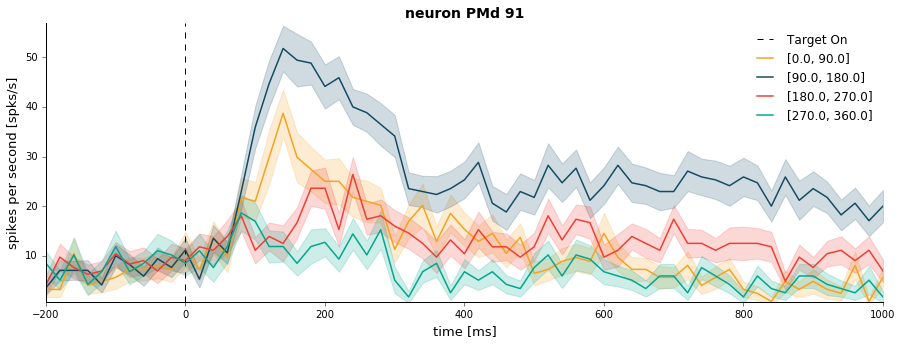

In [7]:
psth_PMd = neuron_PMd.get_psth(events = features['targetOnTime'],
                               features = features,
                               conditions = conditions,
                               window=[-200,1000],
                               binsize=20, 
                               plot=False);

neuron_PMd.plot_psth(psth = psth_PMd,
                     figsize=(15,5),
                     condition_names=condition_names,
                     event_name='Target On');

# psth for M1 neuron

In [8]:
neuron_number = 100
spike_times = M1_neurons[neuron_number-1]
neuron_M1 = psth.PSTH(spike_times, name = 'M1 %d' % neuron_number)

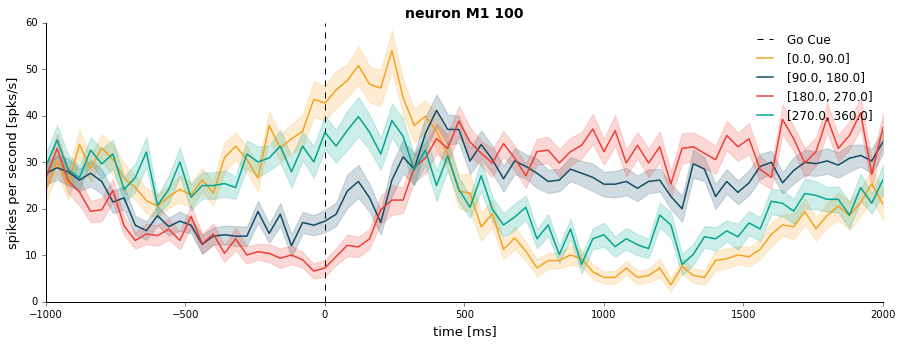

In [9]:
psth_M1 = neuron_M1.get_psth(events = features['goCueTime'],
                            features = features,
                            conditions = conditions,
                            window=[-1000,2000],
                            binsize=40,
                            plot=False);

neuron_M1.plot_psth(psth = psth_M1,
                     figsize=(15,5),
                     condition_names=condition_names,
                     event_name='Go Cue',
                     ylim = [0,60]);

# Let's look at reward vs no reward for this neuron

In [10]:
conditions_reward = dict()

conditions_reward[0] = dict()
conditions_reward[0]['reward'] = [34]

conditions_reward[1] = dict()
conditions_reward[1]['reward'] = [32]

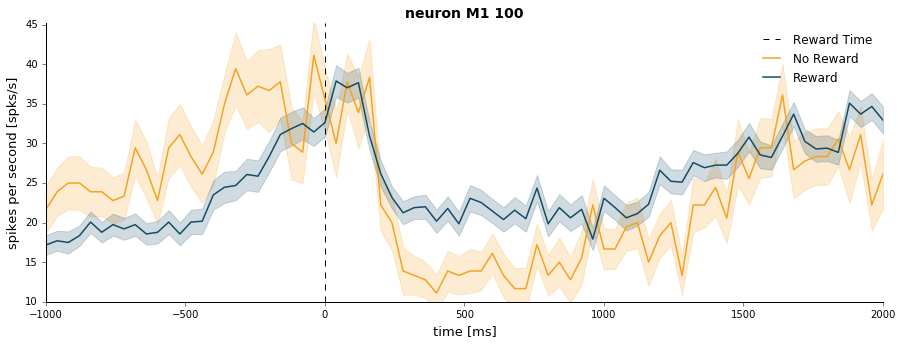

In [11]:
psth_M1 = neuron_M1.get_psth(events = features['rewardTime'],
                            features = features,
                            conditions = conditions_reward,
                            window=[-1000,2000],
                            binsize=40,
                            plot=False);

neuron_M1.plot_psth(psth = psth_M1,
                    figsize=(15,5),
                    event_name='Reward Time',
                    condition_names=['No Reward','Reward']);

# Let's fit tuning curves to the population

In [12]:
from neuropop import NeuroPop

In [158]:
# Extract spike counts for each neuron

PMd_select = list()

threshold = 5.0

x = np.arctan2(np.sin(features['endpointOfReach']*np.pi/180.0),
               np.cos(features['endpointOfReach']*np.pi/180.0))

window = [0.4, 0.8]
Y = np.zeros([x.shape[0], len(PMd_neurons)])
for n in range(len(PMd_neurons)):
    this_neuron = psth.PSTH(spiketimes = PMd_neurons[n])
    Y[:, n] = np.squeeze(this_neuron.get_spikecounts(features['targetOnTime'], window=window))

    # Short list a few high-firing PMd neurons
    if this_neuron.firingrate > threshold:
        PMd_select.append(n)

# Rescale to spikes/s
Y = Y/(window[1]-window[0])

In [159]:
np.shape(x), np.shape(Y[:, PMd_select])

((278, 1), (278, 36))

In [160]:
len(PMd_neurons)

195

In [161]:
# Initialize a population instance
pop = NeuroPop(n_neurons=len(PMd_select), 
               tunemodel='georgopulos', 
               fit_k=True, 
               n_repeats=3,
               learning_rate=1e-2,
               verbose=False)

In [162]:
pop.fit(np.squeeze(x), Y[:, PMd_select])

In [163]:
Yhat = pop.predict(np.squeeze(x))

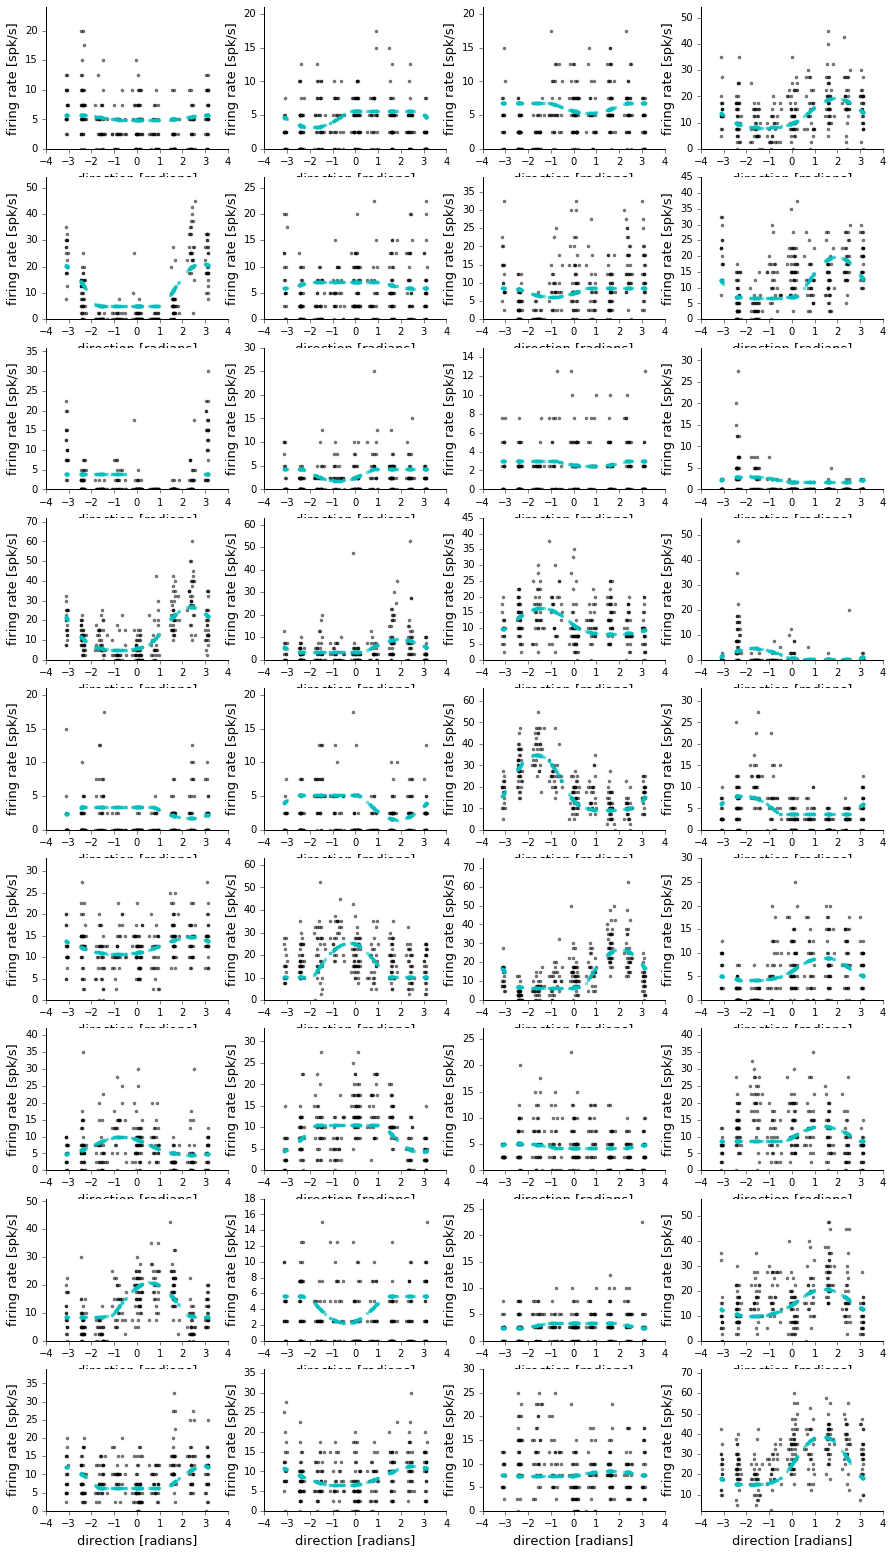

In [164]:
plt.figure(figsize=[15,30])

for neuron in range(len(PMd_select)):
    plt.subplot(10,4,neuron+1)
    pop.display(x, Y[:, PMd_select[neuron]], Yhat[:, neuron], 
                ylim=[0.8*np.min(Y[:, PMd_select[neuron]]), 1.2*np.max(Y[:, PMd_select[neuron]])])
    #plt.axis('off')

plt.show()

In [165]:
xhat = pop.decode(Y[:, PMd_select])

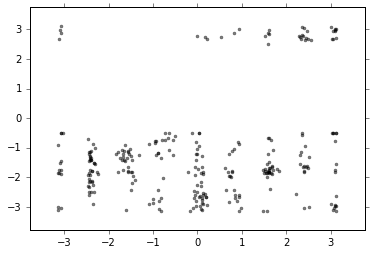

In [166]:
plt.plot(x, xhat, 'k.', alpha=0.5)
plt.xlim([-1.2*np.pi, 1.2*np.pi])
plt.ylim([-1.2*np.pi, 1.2*np.pi])
plt.show()

In [167]:
from scipy import stats
def circ_corr(alpha1, alpha2):
    alpha1_bar = stats.circmean(alpha1)
    alpha2_bar = stats.circmean(alpha2)
    num = np.sum(np.sin(alpha1 - alpha1_bar) * np.sin(alpha2 - alpha2_bar));
    den = np.sqrt(np.sum(np.sin(alpha1 - alpha1_bar) ** 2) * np.sum(np.sin(alpha2 - alpha2_bar) ** 2));
    rho = num / den
    return rho

In [168]:
circ_corr(x, xhat)

9.6313236759663583e-17